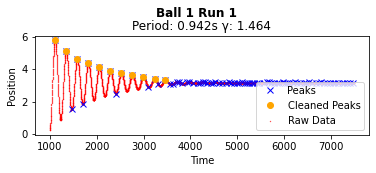

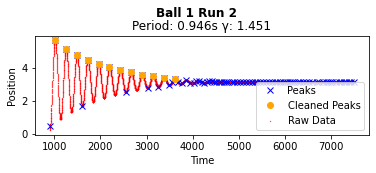

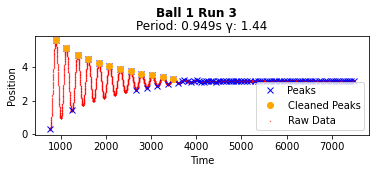

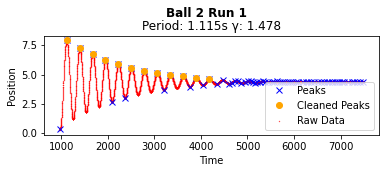

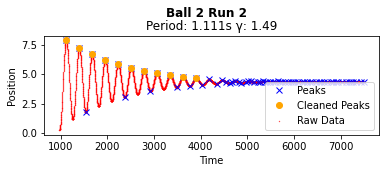

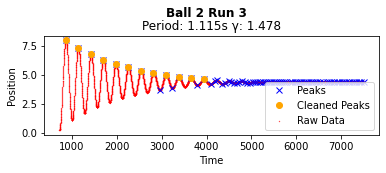

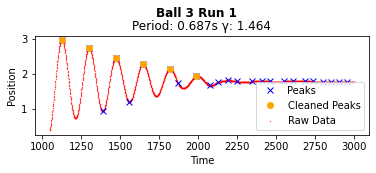

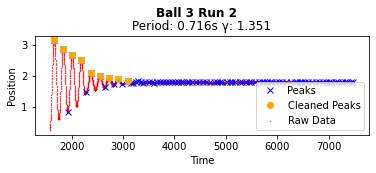

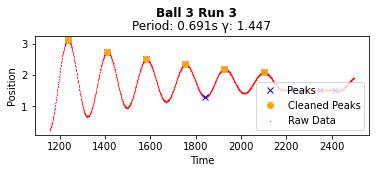

,Ball Number,Run Number,Gamma,Error on Gamma
0,1,1,1.463796,0.038246
1,1,2,1.450768,0.035672
2,1,3,1.439677,0.037102
3,2,1,1.478496,0.032593
4,2,2,1.490426,0.038131
5,2,3,1.478496,0.032413
6,3,1,1.464378,0.059934
7,3,2,1.350829,0.046921
8,3,3,1.447478,0.052978


Mean Gamma: 1.4515937962508842
Error on Mean Gamma: 0.01417654924466435


In [13]:
import pandas as pd
import math
import numpy as np 
from scipy import stats
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
np.set_printoptions(threshold=np.inf)

found_gammas=[]
error_found_gammas=[]

#Ball Masses
m=[25.3352,35.8999,13.4999]

#Equation given in ref. 2 of script for ratio of heat capacities
#m = Mass of Ball, V = Volume of Tube, A = Cross-Sectional Area of the Tube, t = Time Period
def ratio(m,V,A,P,t):
    gamma=(4*(math.pi ** 2)*(m*(10**(-3)))*V)/(P * ((t*0.004)**2)*(A**2))
    return gamma

#Variables for Air
#Wasn't really worth scraping this data as few repeats but maybe it'll get on my nerves and I'll write it in later
P = 1003.4 *(10**2)
V=12.85 *(10**(-3))
d=20 *(10 **(-3))
A=math.pi*((d/2)**2)

#Errors on values
EoM=10**(-7)
EoV=10**(-4)
EoA=(math.pi)*(10**(-6))
EoP=50

def gammaError(gamma,EoM,EoV,EoA,EoP,EoT):
    
    #Error Contributions from partial derivatives
    CoM=gamma/m
    CoV=gamma/V
    CoA=-(2*gamma)/A
    CoP=-(gamma)/P
    CoT=-(2*gamma)/(np.mean(peak_pos_diff)*0.004)
    
    #Breaking up the calculation
    err_mass=(CoM**2)*(EoM**2)
    err_vol=(CoV**2)*(EoV**2)
    err_area=(CoA**2)*(EoA**2)
    err_pressure=(CoP**2)*(EoP**2)
    err_time=(CoT**2)*(EoT**2)
    
    #Cobmine contributions
    gamma_error=(err_mass+err_vol+err_area+err_pressure+err_time)**(1/2)
    
    return gamma_error

for x in range(1,4):                       #Loop over balls
   # print("Ball Number " + str(x))
    for i in range(1,4):                         #Loop over runs for each ball
        #Get data from text file, arguments are just based on formatting of .txt
        df = pd.read_csv('H4/Argon/Ruchardt_Method/Ball_'+str(x)+'_Run_'+str(i)+'.txt', delim_whitespace=True, skiprows=6, error_bad_lines=False )
        
        #Put this data into a list as strings, getting rid of the formatting stuff that isn't numbers
        t_list_str = list(df.iloc[:,2].astype(str).str.slice(start=0,stop=6,step=1))

        #Change list entries of t to floats from strings 
        t_list=[float(u) for u in t_list_str]

        #Get rid of constant times at start
        b=0
        while b<len(t_list):
            if (t_list[b+1]-t_list[b]) < 0.02:
                t_list[b-1]=np.nan    #nan not zero as don't want to plot them
                b+=1
            else:
                b+=len(t_list)
        
        #Clean the weird data that needs it:
        if x==3 and i==1:
            for t in range(3000,7500):
                t_list[t]=np.nan
        if x==3 and i==3:
            for t in range(2500,7500):
                t_list[t]=np.nan
       
        #Initalise array here so they clear every iteration
        orig = np.zeros((2,7500))
        
        #Create 2-D array with orginal values
        orig[0,:]=t_list
        orig[1,:]=range(len(t_list))
        
        #Find Peaks with scipy, min dist between peaks is 45 points
        peaks, _ = find_peaks(orig[0,:], distance=45) 

        #Create new array with only the peaks (no minima)
        #and only the peaks in the larger oscialltion (LHS) part
        clean_peaks = np.zeros((2,7500))
        clean_peaks[1,:] = range(len(t_list))  #x-values
        clean_peaks[clean_peaks==0] = np.nan
        for n in peaks:
            if x==1:
                if orig[0,n]>3.3:  #This is specific to each ball, is the value where it reaches equilbirium(& gets noisy)
                    clean_peaks[0,n]=orig[0,n]
            if x==2:
                if orig[0,n]>4.6:  
                    clean_peaks[0,n]=orig[0,n]
            if x==3:
                if orig[0,n]>1.85:
                    clean_peaks[0,n]=orig[0,n]
        
        #Find the average time periods
        peak_pos=[]
        for n in range(7500):
            if clean_peaks[0,n]>0:
                peak_pos.append(clean_peaks[1,n])
                
        peak_pos_diff=np.diff(peak_pos)                                  #Find difference in positions of peaks(time-period)
     #   print("Run Number " +str(i))                                     
       #print("Mean-Time Period: "+str(np.mean(peak_pos_diff)*0.004))    #Don't forget time-interval is 0.004s
        found_ratio = ratio(m[x-1],V,A,P,np.mean(peak_pos_diff))         #Using variable here as I will need to use in errors
       #print("Gamma: "+str(found_ratio))                                               #My function to find gamma from ref.2 in lab script
        found_gammas.append(ratio(m[x-1],V,A,P,np.mean(peak_pos_diff)))  #Add all values to list to find mean for gas overall
        
        #Find errors
        time_periods=[0.004*i for i in peak_pos_diff]           #Change into seconds
        EoT=stats.sem(time_periods, ddof=4)                     #Find standard error on mean
        error_found_gammas.append(gammaError(found_ratio,EoM,EoV,EoA,EoP,EoT)[0])
        
        
        #Plot time periods
        fig = plt.figure()
        ax0 = fig.add_subplot(211)
        fig.suptitle('Ball '+str(x)+" Run "+str(i), fontsize=12, fontweight='bold')
        ax0.set_title("Period: "+str(round(np.mean(peak_pos_diff)*0.004,3))+"s "+"γ: "+str(round(ratio(m[x-1],V,A,P,np.mean(peak_pos_diff)),3)))
        ax0.scatter(range(len(t_list)),t_list, s=0.1, color='r', label="Raw Data")
        ax0.plot(peaks,orig[0,peaks], "x", label="Peaks", color="b")
        ax0.plot(clean_peaks[1,:],clean_peaks[0,:], "o", label="Cleaned Peaks", color='orange')
        plt.xlabel("Time") 
        plt.ylabel("Position")
        plt.legend(loc='lower right')
        plt.show()
        fig.savefig("pyImg/argon/v2/ball{}_run{}.png".format(x,i),dpi=300)
        
        


dict={'Ball Number': [1,1,1,2,2,2,3,3,3], 'Run Number':[1,2,3,1,2,3,1,2,3], 'Gamma': found_gammas, 'Error on Gamma': error_found_gammas}
t=pd.DataFrame(dict)
display(t)
print("Mean Gamma: "+str(np.mean(found_gammas))) 
sumerravg=[((i)**2)/81 for i in error_found_gammas]
print("Error on Mean Gamma: "+str((np.sum(sumerravg))**(1/2)))


In [2]:
gamma=1.26774
period=1
m=25.3352*(10**(-3))
#Error Analysis
#Errors on values
EoM=10**(-7)
EoV=10**(-4)
EoA=(math.pi)*(10**(-6))
EoP=50
#EoT=0.005 #This is harder 


def gammaError(gamma,EoM,EoV,EoA,EoP,EoT):
    
    #Error Contributions from partial derivatives
    CoM=gamma/m
    CoV=gamma/V
    CoA=-(2*gamma)/A
    CoP=-(gamma)/P
    CoT=-(2*gamma)/period
    
    #Breaking up the calculation
    err_mass=(CoM**2)*(EoM**2)
    err_vol=(CoV**2)*(EoV**2)
    err_area=(CoA**2)*(EoA**2)
    err_pressure=(CoP**2)*(EoP**2)
    err_time=(CoT**2)*(EoT**2)
    
    #Cobmine contributions
    gamma_error=(err_mass+err_vol+err_area+err_pressure+err_time)**(1/2)
    
    return gamma_error
    
gammaError(gamma,EoM,EoV,EoA,EoP,EoT)    

0.4977120140314803